## Setup

In [1]:
!pip install -q catboost

In [2]:
# import plotly.io as pio
# import plotly.graph_objects as go

# # Define a custom dark theme
# dark_theme = {
#     'layout': {
#         'paper_bgcolor': '#1f1f1f',  # Dark gray background
#         'plot_bgcolor': '#1f1f1f',   # Dark gray background for the plot area
#         'font': {
#             'color': '#e1e1e1',      # Light gray text color
#             'family': 'Arial, sans-serif'
#         },
#         'xaxis': {
#             'gridcolor': '#444444',  # Gridlines color
#             'zerolinecolor': '#666666',  # Zero-line color
#         },
#         'yaxis': {
#             'gridcolor': '#444444',  # Gridlines color
#             'zerolinecolor': '#666666',  # Zero-line color
#         },
#         'colorway': ['#ff4d4d', '#4d88ff', '#88ff4d', '#ff884d', '#884dff'],  # Good dark-friendly colors
#     }
# }

# # Apply the theme globally
# pio.templates['dark_theme'] = go.layout.Template(dark_theme)
# pio.templates.default = 'dark_theme'

# print("Dark theme for Plotly applied!")

## Обозначения

- $y_i$: Истинное значение или фактическая метка для $i$-го объекта.

- $\hat{y}_i$: Предсказанное значение для $i$-го объекта, сгенерированное моделью.

- $c$: Константа или параметр в контексте задачи.

- $w_i$: Вес, назначенный $i$-му объекта, часто используется в функции взвешенных потерь.

- $\mathbb{I}(a > b)$: Индикаторная функция, равная $1$, если $a > b$, и $0$ в противном случае.

## Loss vs Metrics

В машинном обучении **loss** и **metric** выполняют разные задачи:

- **Loss**: Скалярная функция, используемая во время обучения для управления оптимизацией. Она количественно определяет ошибку между предсказанными значениями и истинными метками. Например, Mean Squared Error (MSE) или Cross-Entropy Loss. Цель — минимизировать функцию потерь с помощью алгоритмов, таких как градиентный спуск.

- **Metric**: показатель качества модели. Метрики не обязательно дифференцируемы и могут фокусироваться на интерпретируемости (например, Accuracy, F1-Score или ROC-AUC), а не на оптимизации.

Проще говоря:

- **Target metric — это то, что мы хотим оптимизировать**
- **Optimization loss — это то, что оптимизирует модель**

In [30]:
# @title Выбранная метрики определяет оптимальную границу принятия решений
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import minimize

# Data generation
np.random.seed(42)

data_groups = [
    {"center": (0.6, 0.8), "std": 0.2, "class": 1, "n": 200},
    {"center": (0.55, 1.5), "std": 0.15, "class": 1, "n": 200},
    {"center": (0.53, 2.3), "std": 0.15, "class": 1, "n": 200},
    {"center": (1.6, 1.3), "std": 0.2, "class": 2, "n": 150},
    {"center": (0, 0.3), "std": 0.1, "class": 2, "n": 80},
    {"center": (0, 2.4), "std": 0.12, "class": 2, "n": 80},
]

X = []
y = []

for group in data_groups:
    x_group = np.random.normal(group["center"][0], group["std"], group["n"])
    y_group = np.random.normal(group["center"][1], group["std"], group["n"])
    labels = [group["class"]] * group["n"]
    X.extend(zip(x_group, y_group))
    y.extend(labels)

X = np.array(X)
y = np.array(y)
y_binary = np.where(y == 1, 1, 0)  # Convert to binary for logistic regression

# Define logistic regression model
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(w, X, y):
    z = np.dot(X, w)
    preds = sigmoid(z)
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

def custom_loss(w, X, y):
    margin_penalty = np.sum((w[1:] + 1) ** 2)  # Penalize deviation from specific weight
    return log_loss(w, X, y) + 0.4 * margin_penalty

def fit_model(X, y, loss_function):
    X_aug = np.c_[np.ones(X.shape[0]), X]  # Add bias term
    initial_weights = np.zeros(X_aug.shape[1])
    result = minimize(loss_function, initial_weights, args=(X_aug, y), method="BFGS")
    return result.x

# Fit models
w_logloss = fit_model(X, y_binary, log_loss)
w_custom = fit_model(X, y_binary, custom_loss)

# Decision boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx = np.linspace(x_min, x_max, 100)

logloss_boundary = -(w_logloss[0] + w_logloss[1] * xx) / w_logloss[2]
custom_boundary = -(w_custom[0] + w_custom[1] * xx) / w_custom[2]

# Create the plot
fig = go.Figure()

# Add class points
fig.add_trace(
    go.Scatter(
        x=X[y_binary == 0, 0],
        y=X[y_binary == 0, 1],
        mode="markers",
        name="Class 0",
        marker=dict(color="blue", symbol="square", size=7),
    )
)
fig.add_trace(
    go.Scatter(
        x=X[y_binary == 1, 0],
        y=X[y_binary == 1, 1],
        mode="markers",
        name="Class 1",
        marker=dict(color="red", symbol="triangle-up", size=7),
    )
)

# Add decision boundaries
fig.add_trace(
    go.Scatter(
        x=xx,
        y=logloss_boundary,
        mode="lines",
        name="Log-Loss Boundary",
        line=dict(color="green", width=4),
    )
)
fig.add_trace(
    go.Scatter(
        x=xx,
        y=custom_boundary,
        mode="lines",
        name="Custom Loss Boundary",
        line=dict(color="purple", width=4),
    )
)

# Dark theme layout
fig.update_layout(
    title="Logistic Regression with Custom Losses",
    xaxis=dict(
        title="Feature 1",
        range=[x_min, x_max],
        zeroline=False,
        showline=True,
        linecolor="#e1e1e1",
        linewidth=2,
        ticks="outside",
        mirror=True,
    ),
    yaxis=dict(
        title="Feature 2",
        range=[y_min, y_max],
        zeroline=False,
        showline=True,
        linecolor="#e1e1e1",
        linewidth=2,
        ticks="outside",
        mirror=True,
    ),
    paper_bgcolor="#1f1f1f",
    plot_bgcolor="#1f1f1f",
    font=dict(color="#e1e1e1"),
    width=700,
    height=500,
    showlegend=True,
)

# Show the plot
fig.show()

**Почему нам важны метрики в соревнованиях?**
- *Они определяют, как участники ранжируются на лидерборде*

**Почему мы изучаем эти метрики?**
- *Они задают бейзлайн и влияют на создаваемые нами модели.*

## Оптимальные константы

Мы обращаем внимание на константные предсказания, потому что они:

1.	Устанавливают для нас бейзлайн.
2.	Показывают, как метрики ведут себя в простых случаях.
3.	Помогают нам лучше разобраться в подходах к оптимизации некоторых метрик.
4.  В некоторых ML соревнованиях они могут быть решениями на золото или даже призовое место ([link1](https://www.kaggle.com/competitions/two-sigma-financial-modeling), [link2](https://www.topcoder.com/lp/rodeo2)).

# Регрессия
Начнем с регрессии

\begin{align}
\text{MSE} &= \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}i)^2
\end{align}

\begin{align}
\text{MAE} &= \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
\end{align}

In [4]:
# @title Metrics plots
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define the metrics
def mse(y_true, c):
    return np.mean((y_true - c) ** 2)

def mae(y_true, c):
    return np.mean(np.abs(y_true - c))

# True values
y_true = np.array([1, 5, 10, 15, 30])

# Create a range of c values for each y_true
c_ranges = [np.linspace(yi - 4, yi + 4, 100) for yi in y_true]

# Calculate global maximums for MSE and MAE
global_c = np.linspace(-5, 30, 10000)
mse_max = max([mse(y_true, c) for c in global_c])
mae_max = max([mae(y_true, c) for c in global_c])

# Initialize the subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=["MSE", "MAE"])

# Add traces for each metric
for i, c_range in enumerate(c_ranges):
    fig.add_trace(go.Scatter(
        x=c_range,
        y=[mse(np.array([y_true[i]]), c) for c in c_range],
        mode='lines',
        name=f'MSE ({y_true[i]})'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=c_range,
        y=[mae(np.array([y_true[i]]), c) for c in c_range],
        mode='lines',
        name=f'MAE ({y_true[i]})'
    ), row=1, col=2)

# Add global curves
mse_curve = np.array([mse(y_true, c) for c in global_c])
fig.add_trace(go.Scatter(
    x=global_c,
    y=mse_curve,
    mode='lines',
    name='MSE (global)',
    line=dict(dash='dash')
), row=1, col=1)
mae_curve = np.array([mae(y_true, c) for c in global_c])
fig.add_trace(go.Scatter(
    x=global_c,
    y=mae_curve,
    mode='lines',
    name='MAE (global)',
    line=dict(dash='dash')
), row=1, col=2)

# Update layout
fig.update_layout(
    title="MSE and MAE Comparisons vs c",
    width=1000,
    height=500,
    legend_title="Legend"
)
fig.update_yaxes(range=[0, mse_max], row=1, col=1, title="MSE Value")
fig.update_yaxes(range=[0, mae_max], row=1, col=2, title="MAE Value")

# Find optimal constants
mse_optimal_c = global_c[np.argmin(mse_curve)]
mae_optimal_c = global_c[np.argmin(mae_curve)]

# Add vertical lines marking the optimal constants
fig.add_trace(go.Scatter(
    x=[mse_optimal_c, mse_optimal_c],
    y=[0, mse_max],
    mode='lines',
    name=f'MSE Min ({mse_optimal_c:.2f})',
    line=dict(color='red', dash='dot')
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=[mae_optimal_c, mae_optimal_c],
    y=[0, mae_max],
    mode='lines',
    name=f'MAE Min ({mae_optimal_c:.2f})',
    line=dict(color='blue', dash='dot')
), row=1, col=2)

# Show the figure
fig.show()

# Print the optimal constants
print("Optimal Constants:")
print(f"MSE Optimal c: {mse_optimal_c:.2f}")
print(f"MAE Optimal c: {mae_optimal_c:.2f}")

Optimal Constants:
MSE Optimal c: 12.20
MAE Optimal c: 10.00


\begin{align}
\text{MSPE} &= \frac{1}{n} \sum_{i=1}^n \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2
\end{align}

\begin{align}
\text{MAPE} &= \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right|
\end{align}

In [5]:
# @title Metrics plots
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define the metrics
def mspe(y_true, c):
    nonzero_y_true = np.where(y_true != 0, y_true, np.nan)
    return np.nanmean(((y_true - c) / nonzero_y_true) ** 2) * 100

def mape(y_true, c):
    nonzero_y_true = np.where(y_true != 0, y_true, np.nan)
    return np.nanmean(np.abs((y_true - c) / nonzero_y_true)) * 100

# True values
y_true = np.array([1, 5, 10, 15, 30])

# Create a range of c values for each y_true
c_ranges = [np.linspace(yi - 4, yi + 4, 100) for yi in y_true]

# Calculate global maximums for MSPE and MAPE
global_c = np.linspace(-5, 30, 10000)
mspe_max = 2000 # max([mspe(y_true, c) for c in global_c])
mape_max = max([mape(y_true, c) for c in global_c])

# Initialize the subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=["MSPE", "MAPE"])

# Add traces for each metric
for i, c_range in enumerate(c_ranges):
    fig.add_trace(go.Scatter(
        x=c_range,
        y=[mspe(np.array([y_true[i]]), c) for c in c_range],
        mode='lines',
        name=f'MSPE ({y_true[i]})'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=c_range,
        y=[mape(np.array([y_true[i]]), c) for c in c_range],
        mode='lines',
        name=f'MAPE ({y_true[i]})'
    ), row=1, col=2)

# Add global curves
mspe_curve = np.array([mspe(y_true, c) for c in global_c])
fig.add_trace(go.Scatter(
    x=global_c,
    y=mspe_curve,
    mode='lines',
    name='MSPE (global)',
    line=dict(dash='dash')
), row=1, col=1)
mape_curve = np.array([mape(y_true, c) for c in global_c])
fig.add_trace(go.Scatter(
    x=global_c,
    y=mape_curve,
    mode='lines',
    name='MAPE (global)',
    line=dict(dash='dash')
), row=1, col=2)

# Update layout
fig.update_layout(
    title="MSPE and MAPE Comparisons vs c",
    width=1000,
    height=500,
    legend_title="Legend"
)
fig.update_yaxes(range=[0, mspe_max], row=1, col=1, title="MSPE Value")
fig.update_yaxes(range=[0, mape_max], row=1, col=2, title="MAPE Value")

# Find optimal constants
mspe_optimal_c = global_c[np.argmin(mspe_curve)]
mape_optimal_c = global_c[np.argmin(mape_curve)]

# Add vertical lines marking the optimal constants
fig.add_trace(go.Scatter(
    x=[mspe_optimal_c, mspe_optimal_c],
    y=[0, mspe_max],
    mode='lines',
    name=f'MSPE Min ({mspe_optimal_c:.2f})',
    line=dict(color='green', dash='dot'),
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=[mape_optimal_c, mape_optimal_c],
    y=[0, mape_max],
    mode='lines',
    name=f'MAPE Min ({mape_optimal_c:.2f})',
    line=dict(color='orange', dash='dot')
), row=1, col=2)

# Show the figure
fig.show()

# Print the optimal constants
print("Optimal Constants:")
print(f"MSPE Optimal c: {mspe_optimal_c:.2f}")
print(f"MAPE Optimal c: {mape_optimal_c:.2f}")

Optimal Constants:
MSPE Optimal c: 1.33
MAPE Optimal c: 1.00


### MSE vs MAE

Здесь мы немного глубже посмотрим на разницу ключевых метрик для регрессии.


Представим, что у нас есть датасет X, состоящий из одинаковых выборок, и соответствующий вектор целевых значений:

**Y = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1090]**

Если мы обучим модель, используя MSE в качестве функции потерь, она выдаст следующий вектор предсказаний:

**Y_hat = [190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190]**

Если мы обучим модель, используя MAE в качестве функции потерь, она выдаст следующий вектор предсказаний:

**Y_hat = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]**

### Метрики ошибок

Для модели с MSE, ошибки будут такими:
- MSE: 72,900
- MAE: 162
- Mean of residuals: 0
- Median of residuals: 90

Для модели с MAE, ошибки будут такими:
- MSE: 81,000
- MAE: 90
- Mean of residuals: -90
- Median of residuals: 0

### Выбор между MSE и MAE

Выбор между MSE и MAE зависит от значимости выбросов в данных:

- **MSE** сильнее штрафует большие ошибки из-за возведения в квадрат остатка. Подходит для ситуаций, где выбросы имеют значение или большие отклонения несут критические последствия, например, в жизненно важных системах (например, медицинские прогнозы).

- **MAE** одинаково обрабатывает все ошибки, что делает его устойчивым к выбросам. Лучше подходит для случаев, где выбросы не важны, например, для прогнозирования спроса, где ценятся согласованность и надежность.

In [6]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

# Define the dataset
X = np.ones((11, 100))  # Constant feature
Y = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1090])

# Train model with MSE (squared_error)
mse_model = DecisionTreeRegressor(criterion='squared_error')
mse_model.fit(X, Y)
mse_predictions = mse_model.predict(X)

# Train model with MAE (absolute_error)
mae_model = DecisionTreeRegressor(criterion='absolute_error')
mae_model.fit(X, Y)
mae_predictions = mae_model.predict(X)

# Compute errors for analysis
def compute_errors(true, pred):
    mse = np.mean((true - pred) ** 2)
    mae = np.mean(np.abs(true - pred))
    mean_residual = np.mean(true - pred)
    median_residual = np.median(true - pred)
    return mse, mae, mean_residual, median_residual

mse_errors = compute_errors(Y, mse_predictions)
mae_errors = compute_errors(Y, mae_predictions)

# Create a summary dataframe
results_df = pd.DataFrame({
    "Model": ["MSE", "MAE"],
    "MSE": [mse_errors[0], mae_errors[0]],
    "MAE": [mse_errors[1], mae_errors[1]],
    "Mean Residuals": [mse_errors[2], mae_errors[2]],
    "Median Residuals": [mse_errors[3], mae_errors[3]]
})

print(mse_predictions)
print(mae_predictions)

results_df

[190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


,Model,MSE,MAE,Mean Residuals,Median Residuals
0,MSE,81000.0,163.636364,0.0,-90.0
1,MAE,89100.0,90.000000,90.0,0.0


### Weighted MSE

Выше мы видели, что оптимальную константу можно найти перебором, а тут давайте посмотрим на аналитическое решение этой задачи

Consider the loss function:

\begin{align}
L = \sum w_i \cdot (y_i - c)^2
\end{align}

where:

- $\sum w_i = 1$

#### Tasks:

1. **Analytically find the best constant $c$** for the given loss function.
2. **Determine the name of the aggregation of $y_i$'s** at the end if $w_1 = w_2 = \dots = w_n$.

---

#### 1. Analytically Find the Best $c$

To find the optimal $c$, minimize the loss $L$ with respect to $c$. This involves taking the derivative of $L$ with respect to $c$ and setting it to zero:

\begin{align}
\frac{\partial L}{\partial c} = \frac{\partial}{\partial c} \sum w_i \cdot (y_i - c)^2 = 0
\end{align}

Expanding the derivative:

\begin{align}
\frac{\partial L}{\partial c} = \sum w_i \cdot 2 \cdot (y_i - c) \cdot (-1)
\end{align}

Simplify:

\begin{align}
\frac{\partial L}{\partial c} = -2 \sum w_i \cdot (y_i - c)
\end{align}

Set $\frac{\partial L}{\partial c} = 0$:

\begin{align}
\sum w_i \cdot (y_i - c) = 0
\end{align}

Distribute and rearrange:

\begin{align}
\sum w_i \cdot y_i - c \cdot \sum w_i = 0
\end{align}

Since $\sum w_i = 1$, this simplifies to:

\begin{align}
c = \sum w_i \cdot y_i
\end{align}

Thus, the optimal $c$ is the **weighted mean** of $y_i$.

---

#### 2. Aggregation of $y_i$'s When $w_1 = w_2 = \dots = w_n$

If $w_1 = w_2 = \dots = w_n = \frac{1}{n}$, the weights are uniform, and the optimal \(c\) simplifies to:

\begin{align}
c = \sum \frac{1}{n} \cdot y_i = \frac{1}{n} \sum y_i
\end{align}

This is the **arithmetic mean** of $y_i$'s.

# Классификация

### Accuracy

\begin{align}
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} [c = y_i]
\end{align}

---

\begin{align}
\text{Accuracy}(c=1) = \frac{P}{P + N}
\end{align}

\begin{align}
\text{Accuracy}(c=0) = \frac{N}{P + N}
\end{align}

Таким образом, accuracy зависит от предсказания большинства классов, так как оно максимизирует количество правильных предсказаний.

### Precision and Recall

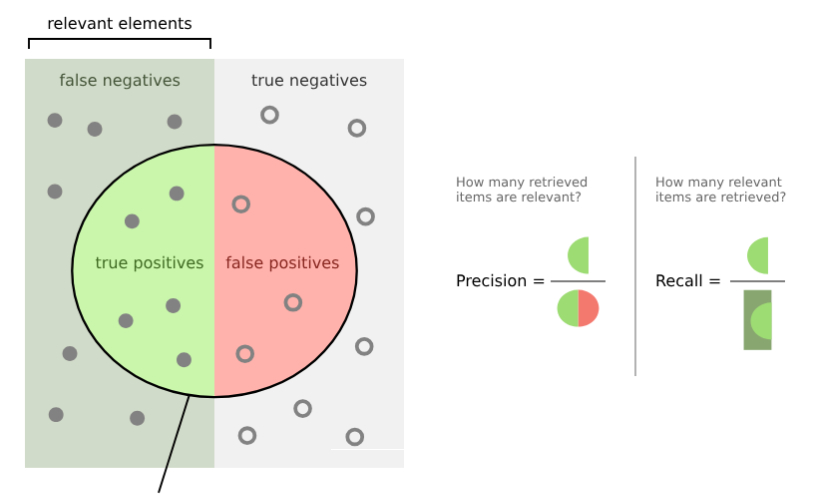

\begin{align}
\text{Precision} &= \frac{TP}{TP + FP} \\[1em]
\text{Recall} &= \frac{TP}{TP + FN}
\end{align}

Как максимизировать precision или recall?

\begin{align}
\text{Recall @ Precision} > 0.95
\end{align}

Зачем организаторам соревнований такая метрика?

Могут ли быть ошибки в имплементации рассчета такой метрики?

In [7]:
# @title Сгенерируем прогнозы
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.isotonic import IsotonicRegression
import plotly.graph_objects as go
from ipywidgets import interact

# Generate synthetic classification dataset
X, y = make_classification(n_samples=10000, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get predictions
predictions = clf.predict_proba(X_test)[:, 1]

In [8]:
# @title Precision Recall curve
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# Find the point where Precision > 0.95
threshold_index = np.where(precision >= 0.95)[0][0]
recall_at_precision = recall[threshold_index]
precision_at_point = precision[threshold_index]

# Plot Precision-Recall curve with Recall on the y-axis and Precision on the x-axis
fig = go.Figure()

# Add Precision-Recall curve
fig.add_trace(go.Scatter(
    x=precision,
    y=recall,
    mode='lines',
    name='Precision-Recall Curve',
    line=dict(color='blue', width=2)
))

# Add the Recall @ Precision > 0.95 point
fig.add_trace(go.Scatter(
    x=[precision_at_point],
    y=[recall_at_precision],
    mode='markers',
    name='Recall @ Precision > 0.95',
    marker=dict(color='red', size=10, symbol='circle'),
))

# Add dotted lines to highlight the point
fig.add_trace(go.Scatter(
    x=[precision_at_point, precision_at_point],
    y=[0, recall_at_precision],
    mode='lines',
    name='Dotted Line (Vertical)',
    line=dict(color='red', width=1, dash='dot')
))

fig.add_trace(go.Scatter(
    x=[0, precision_at_point],
    y=[recall_at_precision, recall_at_precision],
    mode='lines',
    name='Dotted Line (Horizontal)',
    line=dict(color='red', width=1, dash='dot')
))

# Layout with dark theme
fig.update_layout(
    title="Precision-Recall Curve with Recall @ Precision > 0.95",
    xaxis=dict(title="Precision", range=[0, 1], gridcolor='#444444'),
    yaxis=dict(title="Recall", range=[0, 1], gridcolor='#444444'),
    paper_bgcolor='#1f1f1f',
    plot_bgcolor='#1f1f1f',
    font=dict(color='#e1e1e1'),
    width=600,
    height=400
)

# Show the plot
fig.show()

### F-score

\begin{align}
F_\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}
\end{align}

\begin{align}
\text{Visual example if c = 1:}
\end{align}

\begin{align}
\text{y: [1 1 1 1 1 1 0 0 0]}
\end{align}

\begin{align}
\text{c: [1 1 1 1 1 1 1 1 1]}
\end{align}


#### 1. Case $c = 1$ (Predict All Positives)

- **True Positives (TP)**: All positive samples.
- **False Positives (FP)**: All negative samples.
- **False Negatives (FN)**: $0$ (no false negatives since everything is predicted positive).
- **True Negatives (TN)**: $0$ (no true negatives since no negatives are predicted).

Using these definitions:
- Precision:
\begin{align}
Precision = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{P}{P + N}
\end{align}

- Recall:
\begin{align}
Recall = \frac{\text{TP}}{\text{TP} + \text{FN}} = 1
\end{align}

Substitute $Precision$ and $Recall$ into the $F_\beta$-score:
\begin{align}
F_\beta(c=1) = (1 + \beta^2) \cdot \frac{\frac{P}{P + N} \cdot 1}{\beta^2 \cdot \frac{P}{P + N} + 1}
\end{align}

Simplify:
\begin{align}
F_\beta(c=1) = \frac{(1 + \beta^2) \cdot P}{P + N + \beta^2 \cdot P}
\end{align}

#### 2. Case $c = 0$ (Predict All Negatives)

- **True Positives (TP)**: $0$ (no positives are predicted).
- **False Positives (FP)**: $0$ (no negatives are predicted positive).
- **False Negatives (FN)**: All positive samples.
- **True Negatives (TN)**: All negative samples.

Using these definitions:
- Precision:
\begin{align}
Precision = \frac{\text{TP}}{\text{TP} + \text{FP}} = 0
\end{align}

- Recall:
\begin{align}
Recall = \frac{\text{TP}}{\text{TP} + \text{FN}} = 0
\end{align}

Substitute $Precision$ and $Recall$ into the $F_\beta$-score:
\begin{align}
F_\beta(c=0) = 0
\end{align}

Как узнать баланс классов в тестовой выборке?

### Log-Loss

\begin{align}
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(c) + (1 - y_i) \log(1 - c) \right)
\end{align}

\begin{align}
\frac{\partial \text{LogLoss}}{\partial c} = -\frac{1}{N} \sum_{i=1}^N \left[ \frac{y_i}{c} - \frac{1 - y_i}{1 - c} \right]
\end{align}

\begin{align}
\sum_{i=1}^N \left( \frac{y_i}{c} - \frac{1 - y_i}{1 - c} \right) = 0
\end{align}

\begin{align}
\sum_{i=1}^N \left[ y_i (1 - c) - (1 - y_i)c \right] = 0
\end{align}

\begin{align}
\sum_{i=1}^N y_i - c \sum_{i=1}^N y_i - c \sum_{i=1}^N (1 - y_i) = 0
\end{align}

\begin{align}
\sum_{i=1}^N y_i = c \cdot N
\end{align}

\begin{align}
c = \frac{\sum_{i=1}^N y_i}{N} = \text{mean}(y)
\end{align}

In [9]:
# @title Logloss plot
import numpy as np
import plotly.graph_objects as go

# Define the Log Loss function
def log_loss(y_true, c):
    # Clip predictions to avoid log(0) or division by zero
    c = np.clip(c, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(c) + (1 - y_true) * np.log(1 - c))

# True binary labels
y_true = np.array([1, 0, 1, 1, 1])  # Example binary labels

# Range of c values
c_range = np.linspace(0, 1, 1000)

# Calculate log loss values for the range of c
log_loss_values = [log_loss(y_true, c) for c in c_range]

# Find the minimum value of log loss and corresponding c
optimal_c_index = np.argmin(log_loss_values)
optimal_c = c_range[optimal_c_index]
optimal_loss = log_loss_values[optimal_c_index]

# Create the figure
fig = go.Figure()

# Add the log loss curve
fig.add_trace(go.Scatter(
    x=c_range,
    y=log_loss_values,
    mode='lines',
    name='Log Loss',
    line=dict(color='blue')
))

fig.update_yaxes(range=[0, 5])

# Add a vertical line for the optimal constant
fig.add_trace(go.Scatter(
    x=[optimal_c, optimal_c],
    y=[0, optimal_loss],
    mode='lines',
    name=f'Optimal c ({optimal_c:.2f})',
    line=dict(color='red', dash='dot')
))

# Update layout
fig.update_layout(
    title="Log Loss vs Constant",
    xaxis_title="Constant (c)",
    yaxis_title="Log Loss",
    width=800,
    height=500,
    legend_title="Legend"
)

# Show the figure
fig.show()

# Print the optimal constant and log loss
print(f"y: {y_true}")
print(f"Optimal c: {optimal_c:.2f}")
print(f"Minimum Log Loss: {optimal_loss:.2f}")

y: [1 0 1 1 1]
Optimal c: 0.80
Minimum Log Loss: 0.50


In [10]:
import numpy as np

n_cats = 100
n_dogs = 90

min_prop = min(n_cats / (n_cats + n_dogs), n_dogs / (n_cats + n_dogs))
print(min_prop, 1 - min_prop)

# Dataset representation (1 = cat, 0 = dog)
y_true = np.array([1] * n_cats + [0] * n_dogs)  # 10 cats and 90 dogs

# Predicted probabilities based on class frequencies
y_preds = np.linspace(0.001, 0.999, 10000)

# Log-loss calculation
min_loss = float("inf")
min_pred = None
for y_pred in y_preds:
    log_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    if log_loss < min_loss:
        min_loss = log_loss
        min_pred = y_pred

min_pred, min_loss

0.47368421052631576 0.5263157894736843


(0.5262999299929992, 0.6917614993568603)

### ROC-AUC

\begin{align}
\text{AUC} &= \frac{\# \text{ correctly ordered pairs}}{\text{total number of pairs}} \\
&= 1 - \frac{\# \text{ incorrectly ordered pairs}}{\text{total number of pairs}}
\end{align}

- Константные предсказания бессмысленны.
- Случайные предсказания приводят к AUC-оценке $0.5$.


**True Positive Rate (TPR)**:  
\begin{align}
\text{TPR} &= \frac{TP}{TP + FN} \\
\end{align}

   - \(TP\) — количество истинно положительных предсказаний (True Positives).  
   - \(FN\) — количество ложно отрицательных предсказаний (False Negatives).

**False Positive Rate (FPR)**:  
\begin{align}
\text{FPR} &= \frac{FP}{FP + TN}
\end{align}

   - \(FP\) — количество ложно положительных предсказаний (False Positives).  
   - \(TN\) — количество истинно отрицательных предсказаний (True Negatives).

**Precision**:
\begin{align}
Precision = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{align}

**Recall**:
\begin{align}
Recall = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{align}


### Precision and Recall

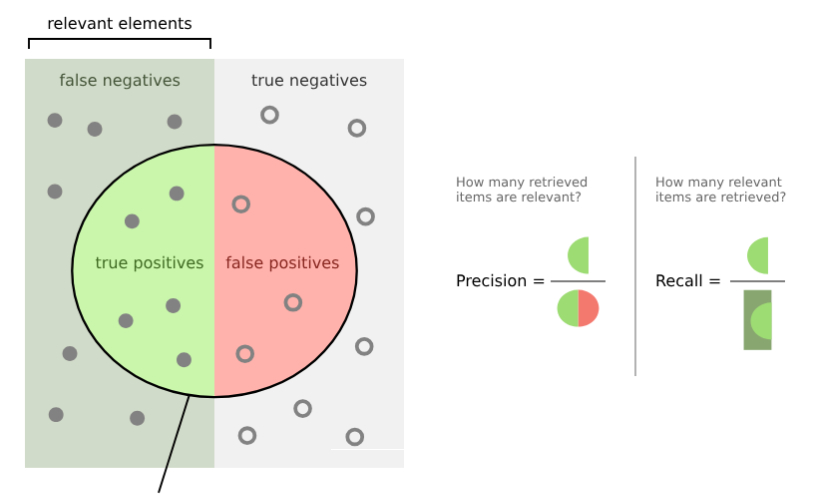

In [31]:
# @title ROC Curve
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go
import numpy as np

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
# y_pred = [0, 0.5, 1]
# после бинаризации с threshold=0.6: [0, 0, 1]

# Create the ROC-AUC plot
fig = go.Figure()

# Add ROC curve
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC Curve (AUC = {roc_auc:.2f})',
    line=dict(color='blue', width=2)
))

# Add diagonal line for random guessing
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Guess',
    line=dict(color='gray', dash='dash')
))

# Layout with dark theme
fig.update_layout(
    title="ROC-AUC Curve",
    xaxis=dict(title="False Positive Rate", range=[0, 1], gridcolor='#444444'),
    yaxis=dict(title="True Positive Rate", range=[0, 1], gridcolor='#444444'),
    paper_bgcolor='#1f1f1f',
    plot_bgcolor='#1f1f1f',
    font=dict(color='#e1e1e1'),
    width=600,
    height=400
)

# Show the plot
fig.show()

In [12]:
import numpy as np
import plotly.graph_objects as go

# Данные
y_true = np.array([0, 0, 0, 1, 1, 1, 0])
y_pred = np.array([0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0])

# Упорядочиваем по убыванию предсказаний
sorted_indices = np.argsort(-y_pred)
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Подсчёт TPR и FPR
n_positives = np.sum(y_true)  # Общее количество положительных
n_negatives = len(y_true) - n_positives  # Общее количество отрицательных

tpr_list = [0]  # Начальное значение TPR (0, 0)
fpr_list = [0]  # Начальное значение FPR (0, 0)

tp, fp = 0, 0  # Начальные значения TP и FP

for label in y_true_sorted:
    if label == 1:
        tp += 1
    else:
        fp += 1
    tpr = tp / n_positives
    fpr = fp / n_negatives
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Построение графика с Plotly
fig = go.Figure()

# Заливка площади под кривой
fig.add_trace(go.Scatter(
    x=fpr_list,
    y=tpr_list,
    fill='tozeroy',  # Заливка до оси Y=0
    mode='none',     # Нет линии
    fillcolor='rgba(255, 0, 0, 0.2)',  # Прозрачный розовый
    name='Area under ROC Curve'
))

# Линия ROC-кривой
fig.add_trace(go.Scatter(
    x=fpr_list,
    y=tpr_list,
    mode='lines',
    name='ROC Curve',
    line=dict(color='red', width=2)
))

# Добавление сетки
for i in range(1, n_negatives + 1):
    fig.add_shape(type="line",
                  x0=i / n_negatives, y0=0, x1=i / n_negatives, y1=1,
                  line=dict(color="gray", dash="dash", width=0.5))

for i in range(1, n_positives + 1):
    fig.add_shape(type="line",
                  x0=0, y0=i / n_positives, x1=1, y1=i / n_positives,
                  line=dict(color="gray", dash="dash", width=0.5))

# Настройки графика
fig.update_layout(
    title="ROC Curve with TPR and FPR (Plotly)",
    xaxis=dict(
        title="False Positive Rate",
        range=[0, 1],
        tickmode='linear',
        tick0=0,
        dtick=1 / n_negatives
    ),
    yaxis=dict(
        title="True Positive Rate",
        range=[0, 1],
        tickmode='linear',
        tick0=0,
        dtick=1 / n_positives
    ),
    showlegend=True,
    width=500,
    height=400
)

# Отображение графика
fig.show()

print("y_true", y_true_sorted)
print("y_pred", y_pred_sorted)
print("tpr", tpr_list)
print("fpr", fpr_list)

y_true [1 0 1 0 1 0 0]
y_pred [0.6 0.5 0.3 0.2 0.2 0.1 0. ]
tpr [0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0]
fpr [0, 0.0, 0.25, 0.25, 0.5, 0.5, 0.75, 1.0]


In [13]:
# @title Корнер кейсы
import plotly.graph_objects as go

# Данные для трёх моделей
# Идеальная модель (AUC = 1)
x_perfect = [0, 0, 1]
y_perfect = [0, 1, 1]

# Случайная модель (AUC = 0.5)
x_random = [0, 1]
y_random = [0, 1]

# Худшая модель (AUC = 0)
x_worst = [0, 1, 1]
y_worst = [0, 0, 1]

# Функция для создания подграфиков
def create_subplot(fig, x, y, row, col, title, color_fill, line_color):
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        fill='tozeroy',
        mode='lines',
        fillcolor=color_fill,
        line=dict(color=line_color, width=2),
        name=title,
        showlegend=False
    ), row=row, col=col)

# Создание фигуры с тремя подграфиками
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=(
    "Идеальная модель (AUC=1)",
    "Случайная модель (AUC=0.5)",
    "Худшая модель (AUC=0)"
))

# Добавляем графики
create_subplot(fig, x_perfect, y_perfect, 1, 1, "Perfect Model", 'rgba(255, 0, 0, 0.5)', 'red')
create_subplot(fig, x_random, y_random, 1, 2, "Random Model", 'rgba(255, 0, 0, 0.5)', 'red')
create_subplot(fig, x_worst, y_worst, 1, 3, "Worst Model", 'rgba(255, 255, 255, 1)', 'red')

# Настройки фигуры
fig.update_layout(
    title="ROC-кривые для идеальной, случайной и худшей моделей",
    height=400,
    width=900,
    showlegend=False,
)

# Обновляем оси для всех подграфиков
for i in range(1, 4):
    fig.update_xaxes(range=[0, 1], row=1, col=i, title="False Positive Rate")
    fig.update_yaxes(range=[0, 1], row=1, col=i, title="True Positive Rate")

# Показываем график
fig.show()

\begin{align}
\text{AUC} = \frac{
    \sum_{i=1}^{q} \sum_{j=1}^{q} \mathbb{I}[y_i < y_j] \mathbb{I}'[a_i < a_j]
}{
    \sum_{i=1}^{q} \sum_{j=1}^{q} \mathbb{I}[y_i < y_j]
},
\end{align}
где
\begin{align}
\mathbb{I}'[a_i < a_j] =
\begin{cases}
0, & \text{если } a_i > a_j, \\
0.5, & \text{если } a_i = a_j, \\
1, & \text{если } a_i < a_j,
\end{cases}
\end{align}
\begin{align}
\mathbb{I}[y_i < y_j] =
\begin{cases}
0, & \text{если } y_i \geq y_j, \\
1, & \text{если } y_i < y_j.
\end{cases}
\end{align}

## Metric optimization

Нам должно уже быть понятно, что не все метрики/лоссы можно оптимизировать напрямую через модели. Например, можно учить модель оптимизировать MSE или Logloss (даже ROC AUC, хотя обычно это не лучше чем оптимизировать Logloss), но нельзя учить модель оптимизировать Accuracy. Давайте поговорим про это

> - **"Remember: not every metric can be a loss function, but every loss function can transform into a metric."**  
>
> - **"A loss function must be globally continuous and differentiable."**  
>
> - **"Loss selection is an important step, but it is even more crucial with deep learning-based systems."**  

\begin{align}
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^N \left[ \mathbb{I}\big(f(x_i) > b\big) = y_i \right]
\end{align}

\begin{align}
\text{Fit any metric and tune treshold!}
\end{align}

In [14]:
# @title Accuracy vs Threshold
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Генерация синтетических данных
np.random.seed(42)
n_samples = 100
X = np.random.rand(n_samples, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)  # Линейная зависимость для целей классификации

# Разделение на обучающую и тестовую выборки
X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказания вероятностей для тестовой выборки
y_probs = model.predict_proba(X_test_2)[:, 1]  # Вероятности принадлежности к классу 1

# Варьирование порога и вычисление accuracy
thresholds = np.linspace(0, 1, 100)
accuracies = [accuracy_score(y_test_2, y_probs >= t) for t in thresholds]
max_threshold = thresholds[np.argmax(accuracies)]

# Визуализация
fig = go.Figure()

# График зависимостей accuracy от порога
fig.add_trace(
    go.Scatter(
        x=thresholds,
        y=accuracies,
        mode="lines",
        name="Accuracy",
        line=dict(color="blue"),
    )
)

# Добавление вертикальной линии для текущего порога
current_threshold = max_threshold
fig.add_trace(
    go.Scatter(
        x=[current_threshold, current_threshold],
        y=[0, 1],
        mode="lines",
        name=f"Threshold = {current_threshold:.2f}",
        line=dict(color="red", dash="dash"),
    )
)

# Настройка интерактивности
fig.update_layout(
    title="Accuracy vs Threshold",
    xaxis=dict(title="Threshold", range=[0, 1]),
    yaxis=dict(title="Accuracy", range=[0, 1]),
    paper_bgcolor='#1f1f1f',
    plot_bgcolor='#1f1f1f',
    font=dict(color='#e1e1e1'),
    width=800,
    height=400
)

fig.show()

#### ROC-AUC

\begin{align}
\text{Run the right model (or just optimize logloss)!}
\end{align}

### Practice

#### Approach: Optimize some loss, use early stopping

Steps:

1. **Optimize metric M1, monitor metric M2**
2. **Stop when M2 score is the best**

In [15]:
import numpy as np
import plotly.graph_objects as go
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=500, n_features=10, n_informative=5, random_state=42
)

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,                  # Keep iterations low for quick visualization
    depth=8,                         # Moderate depth to simulate overfitting
    eval_metric='Logloss',           # Logloss as primary metric
    learning_rate=0.1,               # Set a learning rate
    random_seed=42,
    verbose=0                     # Disable internal logs
)

# Train the model with evaluation set
model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    use_best_model=False,
    plot=False  # Disable internal plot
)

# Extract training and validation metrics
history = model.get_evals_result()
train_error = history['learn']['Logloss']
val_error = history['validation']['Logloss']

# Find stopping point (minimum validation error)
stopping_point = np.argmin(val_error)
stopping_cycle = stopping_point + 1  # Iterations are 1-indexed

# Create the figure
fig = go.Figure()

# Add training error curve
fig.add_trace(go.Scatter(
    x=list(range(1, len(train_error) + 1)),
    y=train_error,
    mode='lines',
    name='Train Error',
    line=dict(color='green')
))

# Add validation error curve
fig.add_trace(go.Scatter(
    x=list(range(1, len(val_error) + 1)),
    y=val_error,
    mode='lines',
    name='Validation Error',
    line=dict(color='orange')
))

# Add stopping point marker
fig.add_trace(go.Scatter(
    x=[stopping_cycle],
    y=[val_error[stopping_point]],
    mode='markers+text',
    name='Stopping Point',
    marker=dict(color='red', size=10),
    text=[f'Stopping Point ({stopping_cycle})'],
    textposition='top center'
))

# Update layout
fig.update_layout(
    title="Training and Validation Error vs Training Cycles",
    xaxis_title="Training Cycles",
    yaxis_title="Error",
    legend_title="Metrics",
    width=800,
    height=500
)

# Show the plot
fig.show()

#### Approach: Define custom loss

```python
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            der1 = targets[index] - p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

model = CatBoostClassifier(loss_function=LoglossObjective())
```

### Use sample weights

MSPE and MAPE could be written as weighted MSE or MAE.

\begin{align}
\text{MSPE} &= \frac{100\%}{N} \sum_{i=1}^N \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2, \quad
w_i = \frac{\frac{1}{y_i^2}}{\sum_{i=1}^N \frac{1}{y_i^2}} \\[1em]
\text{MAPE} &= \frac{100\%}{N} \sum_{i=1}^N \left| \frac{y_i - \hat{y}_i}{y_i} \right|, \quad
w_i = \frac{\frac{1}{y_i}}{\sum_{i=1}^N \frac{1}{y_i}}
\end{align}


### Target transformation

RMSLE could be optimized using target transformation:

\begin{align}
\text{RMSLE} &= \sqrt{\frac{1}{N} \sum_{i=1}^N \left( \log(y_i + 1) - \log(\hat{y}_i + 1) \right)^2} \\
             &= \sqrt{\text{MSE} \left( \log(y_i + 1), \log(\hat{y}_i + 1) \right)}
\end{align}

\begin{align}
\text{Train:}
\end{align}

\begin{align}
1. & \quad \text{Transform target: } z_i = \log(y_i + 1) \\
2. & \quad \text{Fit a model with MSE loss.}
\end{align}

\begin{align}
\text{Test:}
\end{align}

\begin{align}
\text{Transform predictions back: } \hat{y}_i = \exp(\hat{z}_i) - 1
\end{align}

### Probability calibration

\begin{align}
\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
\end{align}

\begin{align}
\text{Just run the right model (or calibrate others)!}
\end{align}

**Correct probabilities:**
- Take all objects with score, e.g., ~0.8:
  - **80% of them** are of class 1.
  - **20% of them** are of class 0.

**Incorrect probabilities:**
- Take all objects with score, e.g., ~0.8:
  - **50% of them** are of class 1.
  - **50% of them** are of class 0.

**Solutions:**

1. **Platt scaling:** Just fit Logistic Regression to your predictions (like in stacking).

2. **Isotonic regression:** Just fit Isotonic Regression to your
predictions (like in stacking).

3. **Stacking:** Just fit XGBoost or neural net to your predictions.

In [16]:
# @title Calibration curve

window_size = 100 # @param {type:"slider", min:100, max:500, step:20}

# Function to compute target rolling mean
def rolling_mean_plot(window_size=100):
    # Sort predictions and corresponding true labels
    sorted_indices = np.argsort(predictions)
    sorted_preds = predictions[sorted_indices]
    sorted_labels = y_test[sorted_indices]

    # Compute rolling mean
    rolling_mean = pd.Series(sorted_labels).rolling(window=window_size, center=True).mean()

    # Calibrate predictions (Isotonic Regression for example)
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    calibrated_preds = iso_reg.fit_transform(sorted_preds, sorted_labels)

    # Plot
    fig = go.Figure()

    # Sorted predictions
    fig.add_trace(go.Scatter(x=np.arange(len(sorted_preds)), y=sorted_preds,
                             mode='lines', name='Sorted predictions',
                             line=dict(color='blue')))

    # Rolling mean
    fig.add_trace(go.Scatter(x=np.arange(len(sorted_preds)), y=rolling_mean,
                             mode='lines', name='Target rolling mean',
                             line=dict(color='red')))

    # Calibrated predictions
    fig.add_trace(go.Scatter(x=np.arange(len(sorted_preds)), y=calibrated_preds,
                             mode='lines', name='Calibrated predictions',
                             line=dict(color='green')))

    # Layout
    fig.update_layout(
        title=f"Probability Calibration With IsotonicRegression (Window Size = {window_size})",
        xaxis_title="Index (sorted by prediction)",
        yaxis_title="Probability",
        paper_bgcolor='#1f1f1f',
        plot_bgcolor='#1f1f1f',
        font=dict(color='#e1e1e1'),
        xaxis=dict(gridcolor='#444444'),
        yaxis=dict(gridcolor='#444444'),
        width=1000,
        height=500,
    )

    fig.show()

# Interactive plot with adjustable window size
rolling_mean_plot(window_size)

# Странные случаи с метриками

In [17]:
# @title Рваная метрика
import numpy as np
import plotly.graph_objects as go

# Генерация данных для регрессии
np.random.seed(42)
y_true = np.random.uniform(0, 10, 100)  # Истинные значения от 0 до 10

# "Рваная" метрика
def jagged_metric(y_true, constant):
    mse = np.mean((y_true - constant) ** 2)  # Mean Squared Error (MSE)

    # Дополнительная "рваность" через условия
    jump_penalty = np.sum(y_true > constant) * 0.4 + np.sum(y_true < constant) * 0.6
    penalty = np.sin(jump_penalty * 5)  # Сочетание синусоидальной части и условий

    return penalty / mse

# Поиск оптимальной константной модели
constants = np.linspace(min(y_true), max(y_true), 1000)  # Константы для перебора
metrics = [jagged_metric(y_true, c) for c in constants]
optimal_constant = constants[np.argmin(metrics)]

# Создание графика с Plotly
fig = go.Figure()

# Линия метрики
fig.add_trace(go.Scatter(
    x=constants,
    y=metrics,
    mode='lines',
    name='Jagged Metric'
))

# Линия оптимальной константы
fig.add_trace(go.Scatter(
    x=[optimal_constant, optimal_constant],
    y=[min(metrics), max(metrics)],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Optimal Constant: {optimal_constant:.2f}'
))

# Настройка графика
fig.update_layout(
    title="Optimization of Constant Model with Jagged Metric",
    xaxis_title="Constant Value",
    yaxis_title="Metric Value",
    legend=dict(x=0.01, y=0.99),
)

# Отображение графика
fig.show()

### Home credit model stability metric.

www.kaggle.com/competitions/home-credit-credit-risk-model-stability

Сабмишены оцениваются с использованием метрики стабильности gini. Gini-оценка вычисляется для предсказаний, соответствующих каждому `WEEK_NUM`.

$ gini = 2 ∗ AUC − 1 $

Линейная регрессия $a ⋅ x + b$ проводится через еженедельные $gini$ оценки, и `falling_rate` рассчитывается как `min(0, a)`. Это используется для штрафа моделей, у которых снижается предсказательная способность.

Наконец, вариабельность предсказаний вычисляется как стандартное отклонение остатков из указанной выше линейной регрессии, применяя штраф за изменчивость модели.

Итоговая метрика вычисляется как:

$ stability\_metric = mean(gini) + 88.0 ⋅ min(0, a) − 0.5 ⋅ std(residuals) $

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression

def gini_score(*args):
    return 2 * roc_auc_score(*args) - 1

In [19]:
random_state = 42
rng = np.random.RandomState(random_state)

gini_dynamics = pd.DataFrame(
    {
        "WEEK_NUM": np.arange(30),
        "Gini": np.linspace(0.8, 0.72, 30) + rng.normal(0, 0.01, 30)
    }
)

lr = LinearRegression()
gini_dynamics["linear_trend"] = lr.fit(gini_dynamics[["WEEK_NUM"]], gini_dynamics["Gini"]).predict(gini_dynamics[["WEEK_NUM"]])
gini_dynamics = gini_dynamics.set_index("WEEK_NUM")
a = lr.coef_[0]
gini_dynamics["res"] = gini_dynamics["linear_trend"] - gini_dynamics["Gini"]
std_res = gini_dynamics["res"].std()

stability_metric = gini_dynamics["Gini"].mean() + 88.0 * min(0, a) - 0.5 * std_res
print(f"Stability Metric: {stability_metric}")

Stability Metric: 0.4802111409013934


In [20]:
# @title Gini plot

print(f"Mean Gini = {gini_dynamics['Gini'].mean()}")
print(f"lr coefs = {lr.coef_}")

# Plotly Visualization
fig = go.Figure()

# Add Gini values
fig.add_trace(go.Scatter(
    x=gini_dynamics.index,
    y=gini_dynamics["Gini"],
    mode='lines+markers',
    name='Gini',
    line=dict(color='blue')
))

# Add Linear Trend
fig.add_trace(go.Scatter(
    x=gini_dynamics.index,
    y=gini_dynamics["linear_trend"],
    mode='lines',
    name='Linear Trend',
    line=dict(color='red', dash='dash')
))


# Configure layout
fig.update_layout(
    title="Gini Dynamics with Linear Trend",
    xaxis_title="Week Number",
    yaxis_title="Gini Value",
    legend=dict(x=0.01, y=0.99),
    width=700,
    height=500,
)

# Show the plot
fig.show()

Mean Gini = 0.7581185310414895
lr coefs = [-0.00311002]


In [21]:
random_state = 42
rng = np.random.RandomState(random_state)

gini_dynamics = pd.DataFrame(
    {
        "WEEK_NUM": np.arange(30),
        "Gini": np.linspace(0.8, 0.72, 30) + rng.normal(0, 0.01, 30)
    }
)
gini_dynamics.Gini = gini_dynamics.Gini - np.linspace(0.08, 0, len(gini_dynamics.Gini))

lr = LinearRegression()
gini_dynamics["linear_trend"] = lr.fit(gini_dynamics[["WEEK_NUM"]], gini_dynamics["Gini"]).predict(gini_dynamics[["WEEK_NUM"]])
gini_dynamics = gini_dynamics.set_index("WEEK_NUM")
a = lr.coef_[0]
gini_dynamics["res"] = gini_dynamics["linear_trend"] - gini_dynamics["Gini"]
std_res = gini_dynamics["res"].std()

stability_metric = gini_dynamics["Gini"].mean() + 88.0 * min(0, a) - 0.5 * std_res
print(f"Stability Metric: {stability_metric}")

Stability Metric: 0.6829697615910485


In [22]:
# @title Gini plot

print(f"Mean Gini = {gini_dynamics['Gini'].mean()}")
print(f"lr coefs = {lr.coef_}")

# Plotly Visualization
fig = go.Figure()

# Add Gini values
fig.add_trace(go.Scatter(
    x=gini_dynamics.index,
    y=gini_dynamics["Gini"],
    mode='lines+markers',
    name='Gini',
    line=dict(color='blue')
))

# Add Linear Trend
fig.add_trace(go.Scatter(
    x=gini_dynamics.index,
    y=gini_dynamics["linear_trend"],
    mode='lines',
    name='Linear Trend',
    line=dict(color='red', dash='dash')
))


# Configure layout
fig.update_layout(
    title="Gini Dynamics with Linear Trend",
    xaxis_title="Week Number",
    yaxis_title="Gini Value",
    legend=dict(x=0.01, y=0.99),
    width=700,
    height=500,
)

# Show the plot
fig.show()

Mean Gini = 0.7181185310414896
lr coefs = [-0.0003514]


### Пример с группировкой данных

In [23]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Simulate dataset
n_ads = 500  # Number of unique ads
n_samples = 10000  # Total number of samples

data = {
    'ad_id': np.random.choice([f'ad_{i}' for i in range(n_ads)], size=n_samples),
    'loc_id': np.random.choice(['loc_1', 'loc_2', 'loc_3'], size=n_samples),
    'audience_segment_id': np.random.choice(['seg_1', 'seg_2', 'seg_3'], size=n_samples),
    'ctr': np.random.uniform(0.01, 0.3, size=n_samples) + np.random.normal(0, 0.02, size=n_samples)
}

# Clip CTR to be between 0 and 1
data['ctr'] = np.clip(data['ctr'], 0, 1)

df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())

    ad_id loc_id audience_segment_id       ctr
0  ad_102  loc_2               seg_2  0.109658
1  ad_435  loc_1               seg_2  0.218522
2  ad_348  loc_3               seg_2  0.196906
3  ad_270  loc_1               seg_1  0.109810
4  ad_106  loc_3               seg_1  0.272594


In [24]:
from sklearn.metrics import mean_squared_error

def calc_optimal_constant(y_true):
    """
    Calculate the optimal constant and corresponding MSE.
    Optimal constant is the mean of the target variable.
    """
    return np.mean(y_true)

# Global optimal constant
global_constant = calc_optimal_constant(df['ctr'])
global_mse = mean_squared_error(df['ctr'], [global_constant] * len(df['ctr']))
print(f"Global Optimal Constant: {global_constant:.4f}")
print(f"Global MSE: {global_mse:.4f}")

Global Optimal Constant: 0.1562
Global MSE: 0.0074


In [25]:
# Calculate group-level MSE
df['group_predictions'] = df.groupby('ad_id')['ctr'].transform(calc_optimal_constant)
grouped_mse = mean_squared_error(df['ctr'], df['group_predictions'])

print(f"Grouped MSE: {grouped_mse:.4f}")

Grouped MSE: 0.0070


In [26]:
# Calculate group-level MSE
df['group_predictions'] = df.groupby(['ad_id', 'loc_id'])['ctr'].transform(calc_optimal_constant)
grouped_mse = mean_squared_error(df['ctr'], df['group_predictions'])

print(f"Grouped MSE: {grouped_mse:.4f}")

Grouped MSE: 0.0063
